In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# From here: https://www.kaggle.com/robertoruiz/sberbank-russian-housing-market/dealing-with-multicollinearity/notebook
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]


In [3]:
location="D:\s_chernov\AnacondaProjects\SberHouse\Data\\"
df_train = pd.read_csv(location+"train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv(location+"test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv(location+"macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)
price_area=pd.read_csv(location+"sqprice.csv",sep=';')

In [4]:
df_train=df_train.drop( df_train.loc[(df_train.full_sq>180) &(df_train.price_doc<10000000)].index)
#df_train=df_train[df_train.timestamp.dt.year>2014]


In [5]:
# ylog will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
ylog_train_all = np.log1p(df_train['price_doc'].values)
y_train_all = (df_train['price_doc'].values)
ysqrt_train_all = np.sqrt(df_train['price_doc'].values)
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')
print(df_all.shape)

# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year']=month_year-201108
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['year'] = df_all.timestamp.dt.year
df_all['dow'] = df_all.timestamp.dt.dayofweek


#df_all=df_all[df_all.year>2013]

(38118, 303)


In [6]:
#____kitchen error
correct=df_all.loc[(df_all.kitch_sq/df_all.full_sq>0.5)].index
df_all.at[correct,'kitch_sq']=8

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)


In [7]:
#not finished building
a=df_all.build_year-df_all.year
a[(a.isnull())|(a<0)]=0
df_all['year']=a

In [8]:
area_mo='Poselenie'
df_all.loc[:,'poselok']=df_all.sub_area.str.contains(area_mo).apply(int)

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp'], axis=1, inplace=True)

In [9]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [10]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]
ylog_train = ylog_train_all[:-num_val]
y_train=y_train_all[:-num_val]
ysqrt_train=ysqrt_train_all[:-num_val]

ylog_val = ylog_train_all[-num_val:]
y_val = y_train_all[-num_val:]
ysqrt_val = ysqrt_train_all[-num_val:]


X_test = X_all[num_train:]

df_columns = df_values.columns

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', ylog_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', ylog_val.shape)
print('X_test shape is', X_test.shape)

(38118L, 311L)
('X_train_all shape is', (30456L, 311L))
('X_train shape is', (24365L, 311L))
('y_train shape is', (24365L,))
('X_val shape is', (6091L, 311L))
('y_val shape is', (6091L,))
('X_test shape is', (7662L, 311L))


In [11]:
dtrain_all = xgb.DMatrix(X_train_all, ysqrt_train_all, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, ysqrt_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, ysqrt_val, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

In [12]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:2685.26
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:1146.71
[40]	val-rmse:660.046
[60]	val-rmse:528.161
[80]	val-rmse:491.259
[100]	val-rmse:478.681
[120]	val-rmse:471.347
[140]	val-rmse:466.891
[160]	val-rmse:464.543
[180]	val-rmse:463.064
[200]	val-rmse:462.159
[220]	val-rmse:461.595
[240]	val-rmse:460.973
[260]	val-rmse:460.664
[280]	val-rmse:460.273
[300]	val-rmse:459.498
[320]	val-rmse:459.666
Stopping. Best iteration:
[304]	val-rmse:459.447



In [13]:
pred = partial_model.predict(dval)
print '________________'
#print r2_score (y_val,np.exp(pred) - 1)
print r2_score (y_val,pred**2)
#print len(pred),min(pred),max(pred)

#0.724200068615
#0.72641375446 - poselenie
#0.728309306415 - kitchen korrect
#0.732036813787 + month_year
#0.734053608465 - drop false prices
#0.734465939044 - not finished build

________________
0.734465939044


In [14]:
score=partial_model.get_score()
#score['poselok']
for i in score:
    if score[i]>10: print i,score[i]



micex_cbi_tr 109
office_sqm_1500 29
ID_metro 28
cafe_sum_1000_max_price_avg 17
month 20
radiation_km 40
trc_sqm_2000 19
cafe_count_5000_price_2500 34
trc_sqm_3000 30
office_sqm_500 19
rel_kitch_sq 74
cafe_sum_2000_max_price_avg 16
build_count_brick 12
big_church_count_2000 11
build_count_block 23
balance_trade 68
max_floor 141
week_year_cnt 67
sport_count_5000 13
trc_count_5000 14
catering_km 55
zd_vokzaly_avto_km 24
trc_sqm_1500 26
water_km 49
green_part_1000 44
ID_railroad_station_walk 14
big_market_km 67
museum_km 42
material 38
park_km 64
railroad_station_walk_min 21
hospice_morgue_km 55
metro_km_avto 63
preschool_quota 35
railroad_station_avto_min 45
micex_rgbi_tr 102
public_transport_station_min_walk 18
public_healthcare_km 65
ice_rink_km 51
balance_trade_growth 45
basketball_km 30
cafe_count_5000 26
build_count_monolith 14
market_shop_km 46
school_education_centers_raion 18
deposits_rate 47
cafe_count_1500_price_1500 12
big_church_km 48
workplaces_km 55
bus_terminal_avto_km 44
e

In [15]:
num_boost_round = partial_model.best_iteration


In [16]:
#model=partial_model
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

In [17]:
#ylog_pred = model.predict(dtest)
#y_pred = np.exp(ylog_pred) - 1
ysqrt_pred = model.predict(dtest)
y_pred = ysqrt_pred**2

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv(location+'sub.csv', index=False)

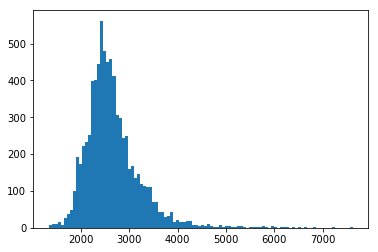

In [18]:
plt.hist(np.sqrt(df_sub.price_doc),100)
plt.show()